# Assignment 1: Least Squares
## Name: Barun Parua
## Roll Number: 21CS10014

## Imports
Here is the list of all the libraries used in this assignment.

In [756]:
# imports

# torchvision for MNIST dataset
from torchvision.datasets import MNIST

# numpy for matrix operations, matplotlib for plotting, pandas for data loading
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

## MNIST Dataset

Here, the MNIST dataset is downloaded and stored separately for training and test data, hence no further splitting is required. 

In [757]:
# fetching and loading the MNIST dataset
mnist_data_train = MNIST('/', train=True, download=True)
mnist_data_test = MNIST('/', train=False, download=True)

## Least Squares Function

Main function of the assignment.

This is the function that calculates the least squares solution for a given matrix A and vector b. It returns the vector x that minimizes the 2-norm of Ax-b.

x is based on the formula: x = inv(A.T @ A) @ A.T @ b

Note that here I have used the @ operator to denote matrix multiplication. Also, the transpose of a matrix A is denoted by A.T. Finally, inv(A) denotes the inverse of a matrix A. Here I have used the pinv function from numpy.linalg to calculate the pseudo-inverse of A, rather than the inverse of A so that the function can handle non-square and singular matrices. (However, A.T @ A is always square and invertible, so this is not necessary here.)

A corresponding function for regularized least squares is also defined, which takes in an additional parameter lambda_. The equation is modified to: x = inv(A.T @ A + lambda_ * I) @ A.T @ b

In [758]:
def least_squares(A, b):
    x = np.linalg.pinv(A.T @ A) @ A.T @ b
    return x

def least_squares_regularized(A, b, lambda_):
    x = np.linalg.pinv(A.T @ A + lambda_ * np.identity(A.shape[1])) @ A.T @ b
    return x

## Question 1

The MNIST dataset is loaded already above. Now, we have to filter the dataset to only include classes 1 and 7 and assign them labels 1 and -1 respectively. After this the images are flattened from matrices of size 28x28 to vectors of length 784. Then, using the least squares function we train the model on train set and report the accuracy and the confusion matrix on the test set.

It can be seen that the accuracy is very high, and the confusion matrix shows that the model is able to distinguish between 1 and 7 very well.

In [759]:
# function to filter the dataset to only include 1s and 7s as per the assignment
def filter_dataset(dataset):
    indices = (dataset.targets == 1) | (dataset.targets == 7)
    images = dataset.data[indices]
    labels = dataset.targets[indices]
    return images, labels

print("Shapes of the train and test data before filtering:", mnist_data_train.data.shape, mnist_data_test.data.shape)

# applying the filter to get the test and train data
X_train, y_train = filter_dataset(mnist_data_train)
X_test, y_test = filter_dataset(mnist_data_test)

# assigning the labels to 1 if class is 1 and -1 if class is 7
y_train = np.where(y_train == 1, 1, -1)
y_test = np.where(y_test == 1, 1, -1)

print(f"Shapes of X_train and X_test before flattening: {X_train.shape}, {X_test.shape}")

# vectorizing the images
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0
print(f"Shapes of X_train and X_test after flattening: {X_train.shape}, {X_test.shape}\n")

# adding a column of 1s to the data for the bias term
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# training the model to get the weights
weights = least_squares(X_train, y_train)

# predicting the labels for the test data
y_pred = np.sign(X_test @ weights)

# reporting the accuracy of the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}\n\nConfusion Matrix:")

# plotting the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)


Shapes of the train and test data before filtering: torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
Shapes of X_train and X_test before flattening: torch.Size([13007, 28, 28]), torch.Size([2163, 28, 28])
Shapes of X_train and X_test after flattening: torch.Size([13007, 784]), torch.Size([2163, 784])



Accuracy: 0.9894

Confusion Matrix:
Predicted  -1.0   1.0
Actual               
-1         1007    21
 1            2  1133


## Question 2

The MNIST dataset is loaded already above. Now, the images are flattened from matrices of size 28x28 to vectors of length 784. Then, using the least squares function we train the model on train set and report the accuracy and the confusion matrix on the test set.

For each class, we have to train a separate model. Fpr this, we select samples of the current class as positive samples and randomly select equal number of samples from the other classes as negative samples to make the dataset balanced. Now using the least squares function we train the model on train set for each of the classes. Auxiliary functions are used so that repeated code is not written.

Now, we have to predict the class of each test sample by using the model that gives the highest score of prediction for that sample and assigning the sample to that class. Finally we report the accuracy and the confusion matrix on the test set.

In [760]:
# define the training and test sets
X_train, y_train = np.array(mnist_data_train.data), np.array(mnist_data_train.targets)
X_test, y_test = np.array(mnist_data_test.data), np.array(mnist_data_test.targets)

# vectorizing the images
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0

# function to filter the dataset to only include class i images for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def filter_dataset(train_x, train_y, class_label):
    indices = (train_y == class_label)
    images = train_x[indices]
    labels = train_y[indices]
    return images, labels

# function to select all images except those of class i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def filter_dataset_not(train_x, train_y, class_label):
    indices = (train_y != class_label)
    images = train_x[indices]
    labels = train_y[indices]
    return images, labels

# function to train the model for a given class label
def train_wrt_class(class_label):
    # class label is the label of the class for which the model is being trained
    # take the images of class and randomly sample the same number of images from the rest of the dataset
    X_train_0, y_train_0 = filter_dataset(X_train, y_train, class_label)
    X_train_0_not, y_train_0_not = filter_dataset_not(X_train, y_train, class_label)

    # randomly sample the same number of images from the rest of the dataset
    indices = np.random.choice(np.arange(len(X_train_0_not)), len(X_train_0))
    X_train_0_not = X_train_0_not[indices]
    y_train_0_not = y_train_0_not[indices]

    # add the images of class 0 and the randomly sampled images from the rest of the dataset
    X_train_0 = np.concatenate((X_train_0, X_train_0_not))
    y_train_0 = np.concatenate((y_train_0, y_train_0_not))

    print(f"Shapes of X_train_0 and y_train_0 after filtering and sampling: {X_train_0.shape}, {y_train_0.shape}")

    # assign the labels to 1 if class is class_label and -1 if class is not class_label
    y_train_0 = np.where(y_train_0 == class_label, 1, -1)
    y_test_0 = np.where(y_test == class_label, 1, -1)

    # train the model to get the weights
    weights_0 = least_squares(X_train_0, y_train_0)

    # predict the labels for the test data
    y_pred_0 = np.sign(X_test @ weights_0)

    # report the accuracy of the model
    accuracy_0 = np.mean(y_pred_0 == y_test_0)
    print(f"\nAccuracy for class {class_label}: {accuracy_0:.4f}\n\nConfusion Matrix for class {class_label}:")

    # plot the confusion matrix
    confusion_matrix_0 = pd.crosstab(y_test_0, y_pred_0, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix_0)
    
    return weights_0

### Class 0

Training of the model for class 0.

In [761]:
# class 0
weights_0 = train_wrt_class(0)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11846, 784), (11846,)

Accuracy for class 0: 0.9715

Confusion Matrix for class 0:
Predicted  -1.0   1.0
Actual               
-1         8749   271
 1           14   966


### Class 1

Training of the model for class 1.

In [762]:
# class 1
weights_1 = train_wrt_class(1)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (13484, 784), (13484,)

Accuracy for class 1: 0.9654

Confusion Matrix for class 1:
Predicted  -1.0   1.0
Actual               
-1         8533   332
 1           14  1121


### Class 2

Training of the model for class 2.

In [763]:
# class 2
weights_2 = train_wrt_class(2)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11916, 784), (11916,)

Accuracy for class 2: 0.9496

Confusion Matrix for class 2:
Predicted  -1.0   1.0
Actual               
-1         8544   424
 1           80   952


### Class 3

Training of the model for class 3.

In [764]:
# class 3
weights_3 = train_wrt_class(3)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (12262, 784), (12262,)

Accuracy for class 3: 0.9164

Confusion Matrix for class 3:
Predicted  -1.0   1.0
Actual               
-1         8206   784
 1           52   958


### Class 4

Training of the model for class 4.

In [765]:
# class 4
weights_4 = train_wrt_class(4)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11684, 784), (11684,)

Accuracy for class 4: 0.9347

Confusion Matrix for class 4:
Predicted  -1.0   1.0
Actual               
-1         8391   627
 1           26   956


### Class 5

Training of the model for class 5.

In [766]:
# class 5
weights_5 = train_wrt_class(5)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (10842, 784), (10842,)

Accuracy for class 5: 0.9112

Confusion Matrix for class 5:
Predicted  -1.0   1.0
Actual               
-1         8280   828
 1           60   832


### Class 6

Training of the model for class 6.

In [767]:
# class 6
weights_6 = train_wrt_class(6)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11836, 784), (11836,)

Accuracy for class 6: 0.9622

Confusion Matrix for class 6:
Predicted  -1.0   1.0
Actual               
-1         8693   349
 1           29   929


### Class 7

Training of the model for class 7.

In [768]:
# class 7
weights_7 = train_wrt_class(7)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (12530, 784), (12530,)

Accuracy for class 7: 0.9516

Confusion Matrix for class 7:
Predicted  -1.0   1.0
Actual               
-1         8535   437
 1           47   981


### Class 8

Training of the model for class 8.

In [769]:
# class 8
weights_8 = train_wrt_class(8)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11702, 784), (11702,)

Accuracy for class 8: 0.8485

Confusion Matrix for class 8:
Predicted  -1.0   1.0
Actual               
-1         7598  1428
 1           87   887


### Class 9

Training of the model for class 9.

In [770]:
# class 9
weights_9 = train_wrt_class(9)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11898, 784), (11898,)

Accuracy for class 9: 0.8828

Confusion Matrix for class 9:
Predicted  -1.0   1.0
Actual               
-1         7879  1112
 1           60   949


### Using the models to get the confidence scores and assigning the class with highest score

Now, we have to predict the class of each test sample by using the model that gives the highest score of prediction for that sample and assigning the sample to that class. Finally we report the accuracy and the confusion matrix on the test set.

In [771]:
# function to predict the class of an image
def predict_class(image):
    # calculate the confidence scores for each class
    confidence_scores = np.array([image @ weights_0, image @ weights_1, image @ weights_2, image @ weights_3, image @ weights_4, image @ weights_5, image @ weights_6, image @ weights_7, image @ weights_8, image @ weights_9])
    
    # return the class with the highest confidence score
    return np.argmax(confidence_scores)

# predicting the classes of the test images
y_pred = np.array([predict_class(image) for image in X_test])

# reporting the accuracy of the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}\n\nConfusion Matrix:")

# plotting the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Accuracy: 0.8764

Confusion Matrix:
Predicted    0     1    2    3    4    5    6    7    8    9
Actual                                                      
0          923     1    3    0    2   19   16    2   11    3
1            0  1081    2    4    1    1    4    1   41    0
2           10    24  831   30   16   10   17   15   66   13
3            8     2   17  886    3   36    6    9   33   10
4            0     9    5    4  891    2    8    1   12   50
5           15    11    0   40    9  717   16    6   61   17
6           11    10    5    3   16   29  867    0   16    1
7           10    26   15   13   17    1    2  847    6   91
8            8    20    8   19   15   29    7   12  835   21
9           10     7    6   16   43    1    0   27   13  886


## Question 3

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-10,10].

Then the target variable b is defined as bi = +1 if pi*qi > 1 and bi = -1 otherwise, for i = 1,2,...,100.

Now we generate 6 basis functions as provided. Then we generate the matrix A of basis functions.

Now, we use the least squares method to find the optimal weights vector x. The optimal weights vector x is given by the formula (A^T A)^-1 A^T b, where A is the matrix of basis functions and b is the target variable vector.

We get the weight vector x in this way and report x as well as the accuracy of the model.

In [772]:
# generate vectors p and q
p = np.random.uniform(-10, 10, 100)
q = np.random.uniform(-10, 10, 100)

# generate the target variable b
b = np.where(p*q > 1, 1, -1)

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# calling the least squares function to calculate the coefficient vector x
x = least_squares(A, b)
print(f'Coefficient vector x: {x}')

# calculating the predicted values
y_pred = np.sign(A @ x)
accuracy = np.mean(y_pred == b)
print(f'Accuracy: {accuracy}')

Coefficient vector x: [-0.15127374  0.00661825 -0.00213449  0.00746268 -0.00163312  0.02303908]
Accuracy: 0.9


## Question 4

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-1,1].

Then the target variable b is defined as pq + p^2 + q^2.

Now we generate 6 basis functions as provided. Then we generate the matrix A of basis functions.

Now, we use the least squares method to find the optimal weights vector x. The optimal weights vector x is given by the formula (A^T A)^-1 A^T b, where A is the matrix of basis functions and b is the target variable vector.

As we can see very easily that the target function is a linear combination of the basis functions, the mean squared error is very close to zero and the weights vector x is very close to [0,0,0,1,1,1] as expected.

In [773]:
# generate vectors p and q
p = np.random.uniform(-1, 1, 100)
q = np.random.uniform(-1, 1, 100)

# generate the target variable b
b = p * q + p**2 + q**2

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# calling the least squares function to calculate the coefficient vector x
x = least_squares(A, b)

# calculating the mse and printing the results
mse = np.mean((A @ x - b)**2)
print("Coefficient vector x:", x)
print("Mean Squared Error (MSE):", mse)

Coefficient vector x: [-4.16333634e-17 -3.88578059e-16  5.55111512e-17  1.00000000e+00
  1.00000000e+00  1.00000000e+00]
Mean Squared Error (MSE): 2.9023990709147387e-31


## Question 5



## Triangular Basis Function

In this question we deal with the triangular basis function. The function to generate the triangular basis function is defined below, so as to reduce repeated code and make the code more readable.

p is again a vector of length 100 sampled from uniform random distribution between [0,1]. b is defined as b = 7p - 3p^2 and we have to generate the coefficients of the triangular basis function.

In [774]:
# generate random vector p of size 100 ranging from 0 to 1
p = np.random.uniform(0, 1, 100)

# define b = 7p - 3p^2
b = 7*p - 3*(p**2)

# basis function matrix generating function
def gen_basis_matrix(p, c):
    A = [[0 for _ in range(c)] for _ in range(100)]
    for i in range(100):
        for j in range(c):
            if j / c <= p[i] and p[i] < (j + 1) / c:
                A[i][j] = ((2 * j + 1) / (2 * c) - np.abs(p[i] - (2 * j + 1) / (2 * c))) * 2 * c
            else:
                A[i][j] = 0
    return A

### Part A (Normal Least Squares)

Normal least squares method is used to find the optimal weights vector x. The optimal weights vector x is given by the formula (A^T A)^-1 A^T b, where A is the matrix of basis functions and b is the target variable vector. The coefficient vector x and the mean squared error are reported.

cols = 10

In [775]:
# number of basis functions = 10
A = np.array(gen_basis_matrix(p, 10))

# least squares solution
x = least_squares(A, b)

# calculate the mse and print the results
mse = np.mean((A @ x - b)**2)
print("Results for 10 basis functions:")
print("Coefficient vector x:", x)
print("Mean Squared Error (MSE):", mse)

Results for 10 basis functions:
Coefficient vector x: [0.52989646 0.37446158 0.32449669 0.31336991 0.28758862 0.28614795
 0.26047314 0.246009   0.23117226 0.21201029]
Mean Squared Error (MSE): 0.011949275539820543


cols = 50

In [776]:
# number of basis functions = 50
A = np.array(gen_basis_matrix(p, 50))

# least squares solution
x = least_squares(A, b)

# calculate the mse and print the results
mse = np.mean((A @ x - b)**2)
print("Results for 50 basis functions:")
print("Coefficient vector x:", x)
print("Mean Squared Error (MSE):", mse)

Results for 50 basis functions:
Coefficient vector x: [0.12853216 0.07410061 0.08805355 0.07237936 0.06758563 0.07115303
 0.06621473 0.06556665 0.06516195 0.         0.06608475 0.0648786
 0.06317397 0.06408399 0.         0.         0.06069726 0.05957666
 0.05917247 0.05885073 0.05779375 0.05730726 0.05670395 0.056162
 0.         0.0549932  0.         0.05379546 0.05353958 0.05239124
 0.0522851  0.05139442 0.05066801 0.05010746 0.04942539 0.04882525
 0.         0.0476317  0.04709393 0.046514   0.04595399 0.0452536
 0.04468501 0.         0.04368528 0.0429372  0.04220448 0.04170576
 0.04142716 0.04049737]
Mean Squared Error (MSE): 0.00027383897682547304


### Part B (Regularized Least Squares)

Here we do the same thing as in part A, but using regularized least squares instead of least squares. The lambda_ parameter is randomly sampled from a uniform distribution between [0,0.2].

The values of n in this cases are 150 and 200. The least squares regularized method is used to find the optimal weights vector x. The optimal weights vector x is given by the formula (A^T A + lambda_ * I)^-1 A^T b, where A is the matrix of basis functions and b is the target variable vector. Note that here x is commented out as it takes too much space to print and only the mse is reported. If required, please uncomment the print statement to see the value of x.

cols = 150

In [777]:
# number of basis functions = 150
A = np.array(gen_basis_matrix(p, 150))

# pick 5 random values of lambda from 0 to 0.2
lambdas = np.random.uniform(0, 0.2, 5)
for lambda_ in lambdas:
    # least squares regularized solution
    x = least_squares_regularized(A, b, lambda_)

    # calculate the mse and print the results
    mse = np.mean((A @ x - b)**2)
    print(f"Results for 150 basis functions and lambda = {lambda_}:")
    # print("Coefficient vector x:", x)
    print("Mean Squared Error (MSE):", mse)
    print()

Results for 150 basis functions and lambda = 0.07920156742667968:
Mean Squared Error (MSE): 3.349932390338421e-05

Results for 150 basis functions and lambda = 0.11247038327429873:
Mean Squared Error (MSE): 3.3506971046111705e-05

Results for 150 basis functions and lambda = 0.1876557025296374:
Mean Squared Error (MSE): 3.3533752732644586e-05

Results for 150 basis functions and lambda = 0.06737113739365093:
Mean Squared Error (MSE): 3.3497235428116944e-05

Results for 150 basis functions and lambda = 0.19985665134604744:
Mean Squared Error (MSE): 3.353932261402073e-05



cols = 200

In [778]:
# number of basis functions = 200
A = np.array(gen_basis_matrix(p, 200))

# pick 5 random values of lambda from 0 to 0.2
lambdas = np.random.uniform(0, 0.2, 5)
for lambda_ in lambdas:
    # least squares regularized solution
    x = least_squares_regularized(A, b, lambda_)

    # calculate the mse and print the results
    mse = np.mean((A @ x - b)**2)
    print(f"Results for 200 basis functions and lambda = {lambda_}:")
    # print("Coefficient vector x:", x)
    print("Mean Squared Error (MSE):", mse)
    print()

Results for 200 basis functions and lambda = 0.01735332551919602:
Mean Squared Error (MSE): 1.3913991556359146e-05

Results for 200 basis functions and lambda = 0.009376553305537261:
Mean Squared Error (MSE): 1.3913853208780613e-05

Results for 200 basis functions and lambda = 0.1212889801801939:
Mean Squared Error (MSE): 1.3923158178235764e-05

Results for 200 basis functions and lambda = 0.16617395676985997:
Mean Squared Error (MSE): 1.3931220541498528e-05

Results for 200 basis functions and lambda = 0.06734116165988846:
Mean Squared Error (MSE): 1.3916712006637285e-05



## Question 6

Here we have a csv file with various kinds of data. However according to the assignment, we only have to consider the consumption column as the data and build a auto-regressive model for it. We take the last 8 values of the consumption column as the lagged values and the current value as the target variable.

This way, we build the matrix A of data points and the vector b of target variables. Then we use the least squares method to find the optimal weights vector x. As we know that the last 8 values of the consumption column are the lagged values, we can use the last 8 values of the weights vector x to predict the next value of the consumption column.

Finally, the weights vector x and the next day's predicted value of the consumption column are reported.

In [779]:
# loading the dataset
data = pd.read_csv('q6.csv')

# extracting the consumption column and converting it to a numpy array
y = np.array(data['Consumption'])
print("Mean of Consumption:", np.mean(y))
# print("Shape of Consumption:", y.shape)

# creating a new dataset where lag_1 to lag_8 are the features and the next value of consumption is the target variable
X = np.zeros((len(y) - 8, 8))
for i in range(len(y) - 8):
    X[i] = y[i:i+8]
print("Lagged data:", X)
y = y[8:]
print("Target variable:", y)

# fit the model using least squares
weights = least_squares(X, y)

# y_new is the last 8 values of the consumption column
# y_pred is the predicted value for the next day
y_new = y[-8:]
y_pred = y_new @ weights

# print the results
print("\nWeights:", weights)
print("Predicted value for the next day:", y_pred)

Mean of Consumption: 1338.6758355897787
Lagged data: [[1069.184   1380.521   1442.533   ... 1403.427   1300.287   1207.985  ]
 [1380.521   1442.533   1457.217   ... 1300.287   1207.985   1529.323  ]
 [1442.533   1457.217   1477.131   ... 1207.985   1529.323   1576.911  ]
 ...
 [1520.37206 1423.23782 1272.17085 ... 1130.11683 1263.94091 1299.86398]
 [1423.23782 1272.17085 1141.7573  ... 1263.94091 1299.86398 1295.08753]
 [1272.17085 1141.7573  1111.28338 ... 1299.86398 1295.08753 1215.44897]]
Target variable: [1529.323   1576.911   1577.176   ... 1295.08753 1215.44897 1107.11488]

Weights: [-0.48031652  0.79451371  0.0741064   0.00317865 -0.04130348  0.08092347
 -0.08570714  0.65400841]
Predicted value for the next day: 1093.2953728795715


## Question 7



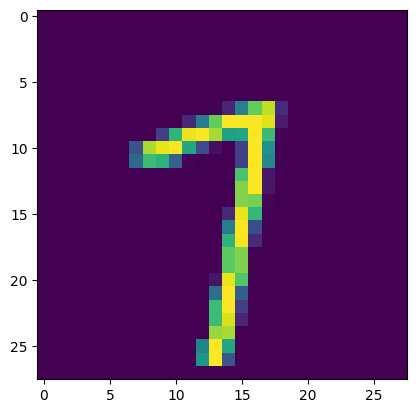

In [794]:
# get the image from MNIST dataset
image = np.array(mnist_data_train.data[42])
plt.imshow(image)
flat_image = image.flatten()

Toeplitz matrix of the kernel:
 [[0.0625 0.125  0.0625 ... 0.     0.     0.    ]
 [0.125  0.0625 0.125  ... 0.     0.     0.    ]
 [0.0625 0.125  0.0625 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.0625 0.125  0.0625]
 [0.     0.     0.     ... 0.125  0.0625 0.125 ]
 [0.     0.     0.     ... 0.0625 0.125  0.0625]]


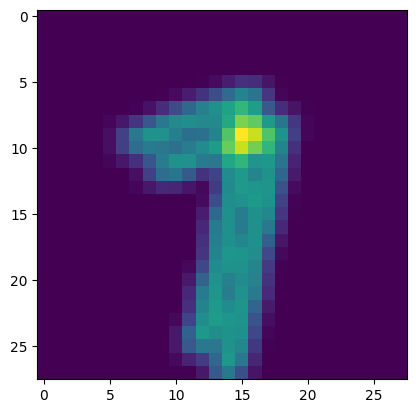

In [797]:
# define the kernel vector
kernel = np.zeros(784)
kernel[0], kernel[1], kernel[2] = 1/16, 1/8, 1/16
kernel[28], kernel[29], kernel[30] = 1/8, 1/4, 1/8
kernel[56], kernel[57], kernel[58] = 1/16, 1/8, 1/16

# get the toeplitz matrix of the kernel
kernel = np.reshape(kernel, (28, 28))
toeplitz_kernel = sp.linalg.toeplitz(kernel)
print("Toeplitz matrix of the kernel:\n", toeplitz_kernel)

# get the blurred image by convolving the image with the kernel or multiplying the toeplitz matrix with the flattened image
blurred_image = toeplitz_kernel @ flat_image

# reshape the blurred image to 28x28
blurred_image = np.reshape(blurred_image, (28, 28))
plt.imshow(blurred_image)

Shape of matrix D: (27, 28)
Shape of matrix Dv: (756, 784)
Shape of matrix Dh: (756, 784)
Shape of matrix A: (2296, 784)
Shape of vector b: (2296,)
Shape of vector x: (784,)


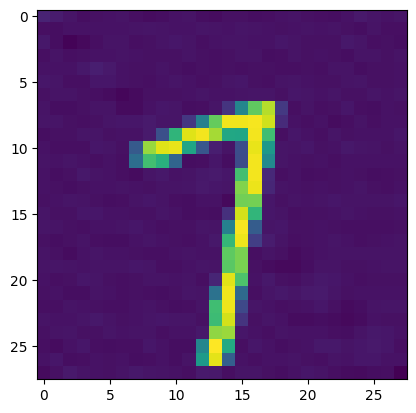

In [837]:
# deblur the image using the least squares solution
I27 = np.identity(27)
MI27 = -I27
I28 = np.identity(28)
MI28 = -I28

# stack an additional column of zeros to the right of MI27 and an additional row of zeros to the left of I27 and add them to get the matrix D
D = np.hstack((np.zeros((27, 1)), I27)) + np.hstack((MI27, np.zeros((27, 1))))
print("Shape of matrix D:", D.shape)

# matrix Dv using D as the diagonal block element
Dv = sp.linalg.block_diag(*([D] * 28))
print("Shape of matrix Dv:", Dv.shape)

# get the stacked matrices I28*27 and MI28*27
I28_27 = sp.linalg.block_diag(*([I28] * 27))
# print("Shape of matrix I28_27:", I28_27.shape)
MI28_27 = sp.linalg.block_diag(*([MI28] * 27))

# stack an additional column of zeros to the right of MI28_27 and an additional row of zeros to the left of I28_27 and add them to get the matrix Dh
Dh = np.hstack((np.zeros((756, 28)), I28_27)) + np.hstack((MI28_27, np.zeros((756, 28))))
print("Shape of matrix Dh:", Dh.shape)

# stack matrices toeplitz_kernel, Dv and Dh to get the matrix A
lambda_ = 0.007
Dv, Dh = lambda_ * Dv, lambda_ * Dh
A = np.vstack((toeplitz_kernel, Dv, Dh))
print("Shape of matrix A:", A.shape)

# similarly stack the blurred image, zeros and zeros to get the vector b
b = np.hstack((blurred_image.flatten(), np.zeros(756), np.zeros(756)))
print("Shape of vector b:", b.shape)

# calculate the least squares solution
x = least_squares(A, b)
print("Shape of vector x:", x.shape)

# deblur the image using the least squares solution
deblurred_image = np.reshape(x, (28, 28))
plt.imshow(deblurred_image)

## Question 8
### Note: This is the same question as 4, just that we use the analytical solution there and here we use the gradient descent algorithm.

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-1,1].

Then the target variable b is defined as pq + p^2 + q^2.

Now we generate 6 basis functions as provided in order to implement the gradient descent algorithm to find the optimal weights vector x. Then we generate the matrix A of basis functions.

Gradient descent algorithm is implemented using the cost function and the update weights function. x (here theta) is initialized as a random vector of length 6.

The learning rate is set as 0.01 so that the algorithm converges to the optimal weights vector and the number of iterations is set as 50000. The cost graph is plotted to see how the cost function decreases with the number of iterations.

As we can see very easily that the target function is a linear combination of the basis functions, the mean squared error is very close to zero and the weights vector x (or theta) is very close to [0,0,0,1,1,1] as expected.

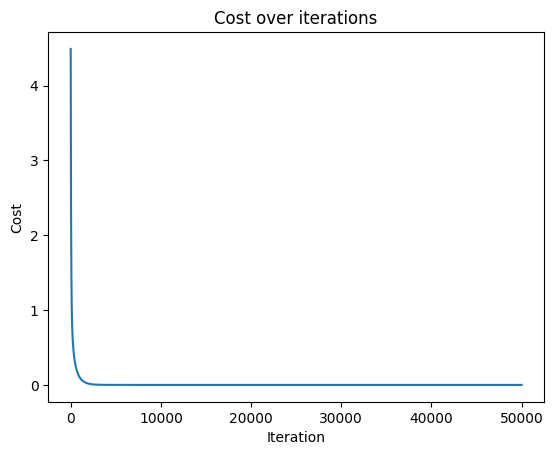

Coefficient vector x: [4.57437603e-14 7.73210152e-15 6.65903014e-15 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Mean Squared Error (MSE): 1.0919476201243511e-27


In [780]:
# generate vectors p and q
p = np.random.uniform(-1, 1, 100)
q = np.random.uniform(-1, 1, 100)

# generate the target variable b
b = p * q + p**2 + q**2

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# gradient descent functions
# cost function
def cost(x,y,theta):
    return np.sum((x @ theta - y)**2)/(2*len(y))

# gradient descent function which updates theta
def gradient_descent(x,y,theta,learning_rate):
    return theta - learning_rate * x.T @ (x @ theta - y) / len(y)

# doing the gradient descent and plotting the cost function over iterations
# random initial theta
theta = np.random.randn(6)
# print("Initial theta:", theta)

learning_rate = 0.01
num_iterations = 50000
cost_history = np.zeros(num_iterations)

for i in range(num_iterations):
    theta = gradient_descent(A,b,theta,learning_rate)
    cost_history[i] = cost(A,b,theta)
plt.plot(cost_history)
plt.title("Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

# calculating the mse and printing the results
mse = np.mean((A @ theta - b)**2)
print("Coefficient vector x:", theta)
print("Mean Squared Error (MSE):", mse)

## Question 9

Here, based on the given data, we have to fit 3 piece wise polynomial functions on the interval [0,1] and [1,2] and [2,3] respectively for f1, f2 and f3.

It is given that f1 is degree 2 polynomial, f2 is degree 3 polynomial and f3 is degree 2 polynomial. Further, to impose continuity and differentiability at the boundaries, some additional constraints are added.

f1(1) = f2(1) and f2(2) = f3(2) and f2'(2) = f3'(2)

Now, we have to find the optimal weights vector x1, x2 and x3 for f1, f2 and f3 respectively, using the least squares method. 

We get,
f1(x) = 4.00 + -3.00x + 1.00x^2

f2(x) = 1.00 + 0.00x + -2.00x^2 + 3.00x^3

f3(x) = -35.00 + 24.00x + 1.00x^2

We see that the required polynomials also satisfy the given constraints. (Note that f1'(1) != f2'(1), but it is not our constraint.)

Finally, the data points and the fitted polynomials are plotted to see how well the polynomials fit the data, it can be seen that our polynomials fit the data very well.

Function for part 1 = 4.00 + -3.00x + 1.00x^2
Function for part 2 = 1.00 + 0.00x + -2.00x^2 + 3.00x^3
Function for part 3 = -35.00 + 24.00x + 1.00x^2

Constraints:
f1(1) = 2.00
f2(1) = 2.00
f2(2) = 17.00
f3(2) = 17.00
f2'(2) = 28.00
f3'(2) = 28.00


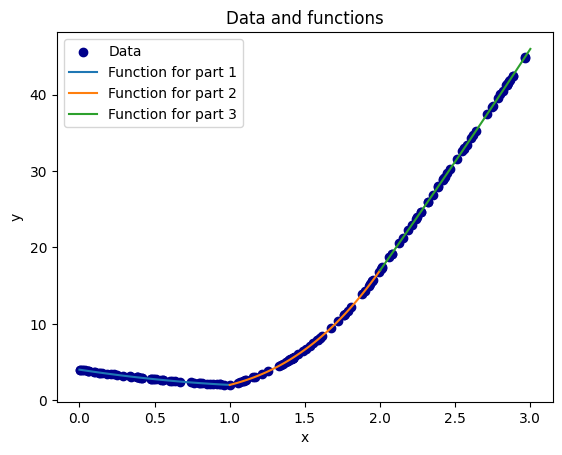

In [781]:
# loading the data
data = pd.read_csv("q9.csv")
data = data.values

# dividing the data into three parts
part_1 = data[(data[:, 0] >= 0) & (data[:, 0] <= 1)]
part_2 = data[(data[:, 0] > 1) & (data[:, 0] <= 2)]
part_3 = data[(data[:, 0] > 2) & (data[:, 0] <= 3)]

# defining the evaluation function
def f(params, x):
    return np.polyval(params, x)

# least squares function for polynomial regression which returns the parameters
def least_squares_poly(part, degree):
    x = part[:, 0]
    y = part[:, 1]
    X = np.vander(x, degree + 1)

    params = least_squares(X, y)
    return params

# calculating the parameters for the 3 parts
params_1 = least_squares_poly(part_1, 2)
params_2 = least_squares_poly(part_2, 3)
params_3 = least_squares_poly(part_3, 2)

# printing the functions
print("Function for part 1 = {:.2f} + {:.2f}x + {:.2f}x^2".format(params_1[2], params_1[1], params_1[0]))
print("Function for part 2 = {:.2f} + {:.2f}x + {:.2f}x^2 + {:.2f}x^3".format(params_2[3], params_2[2], params_2[1], params_2[0]))
print("Function for part 3 = {:.2f} + {:.2f}x + {:.2f}x^2".format(params_3[2], params_3[1], params_3[0]))

print("\nConstraints:")

# check continuity
print("f1(1) = {:.2f}".format(f(params_1, 1)))
print("f2(1) = {:.2f}".format(f(params_2, 1)))
print("f2(2) = {:.2f}".format(f(params_2, 2)))
print("f3(2) = {:.2f}".format(f(params_3, 2)))

# check differentiability
print("f2'(2) = {:.2f}".format(f(np.polyder(params_2), 2)))
print("f3'(2) = {:.2f}".format(f(np.polyder(params_3), 2)))

# plotting the data and the functions to compare
plt.scatter(data[:, 0], data[:, 1], label="Data", color="darkblue")

x = np.linspace(0, 1, 100)
plt.plot(x, f(params_1, x), label="Function for part 1")
x = np.linspace(1, 2, 100)
plt.plot(x, f(params_2, x), label="Function for part 2")
x = np.linspace(2, 3, 100)
plt.plot(x, f(params_3, x), label="Function for part 3")

plt.title("Data and functions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Conclusion

This assignment was based on least squares method and its applications. We saw how to use least squares method to solve linear regression problems and classification problems. We also saw how to use least squares method to solve polynomial fitting problems.

Thank you.